<center><span style='font-size: 25px;'>ПРЕДСКАЗАНИЕ ДОЖДЯ В АВСТРАЛИИ</span></center>

<img src='data/pics/descr_1.png' width='70%' style='display:block; margin:auto;' />
<img src='data/pics/descr_2.png' width='70%' style='display:block; margin:auto;' />
<br />
<img src='data/pics/descr_3.png' width='70%' style='display:block; margin:auto;' />

<h2 id='contents'>Оглавляшка:</h2>

0. [Загружаемые библиотеки](#libs)

<center><span style="font-size:25px;">

Практика `Random Forest`</span></center> 

1. [Загрузка данных](#intro)
2. [Небольшой feature ingeneering](#featureengineering) удаление пропусков, извлечение месяца из даты и кодирование столбцов
3. [Разбиение выборки на train и test](#trainttestsplit) + доудаление пропусков
4. [Бутстреп реализованный вручную](#ex_4_7)
5. [Логистическая регрессия без параметров](#ex_4_8)
6. [DecisionTreeClassifier через GridSearch](#ex_4_9)
7. [RandomForest](#ex_4_10) n_estimators=100
8. [RandomForest через GridSearch](#ex_4_11)
9. [Feature importances для модели GridSearch](#ex_4_12)

## Загружаемые библиотеки <a id='libs'></a>

In [1]:
from data.functions_akialema import *

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import roc_auc_score

from sklearn.model_selection import GridSearchCV

plt.style.use('seaborn-v0_8') #стиль отрисовки seaborn
%matplotlib inline

## Загрузка данных <a id='intro'></a>

In [2]:
df = pd.read_csv('https://drive.google.com/uc?export=download&confirm=no_antivirus&id=1du_iRetQfvk6Y3oq3ikFL6B511pRNd7I')

my_info(df)

memory usage: 80.1 MB


,column,num of unique vals,type,mode,number of entries,NaN vals,number of dublics,describe
0,RainToday,2,object,No,145460,3261,0,see type column
1,RainTomorrow,2,object,No,145460,3267,0,see type column
2,Cloud3pm,10,float64,7.0,145460,59358,0,min...: 0.00max..: 9.00mean: 4.51std....: 2.72
3,Cloud9am,10,float64,7.0,145460,55888,0,min...: 0.00max..: 9.00mean: 4.45std....: 2.89
4,WindDir3pm,16,object,SE,145460,4228,0,see type column
5,WindDir9am,16,object,N,145460,10566,0,see type column
6,WindGustDir,16,object,W,145460,10326,0,see type column
7,WindSpeed9am,43,float64,9.0,145460,1767,0,min...: 0.00max..: 130.00mean: 14.04std....: 8.92
8,WindSpeed3pm,44,float64,13.0,145460,3062,0,min...: 0.00max..: 87.00mean: 18.66std....: 8.81
9,Location,49,object,Canberra,145460,0,0,see type column


[↑ contents](#contents)

## Небольшой feature ingeneering <a id='featureengineering'></a>

In [3]:
print(f"Задание 4.1: сколько пропусков в целом?\n{'-'*38}\nОтвет: {df.isna().sum().sum()}\n")

nan_percent = df.isna().sum() / df.shape[0] * 100
print(f"Задание 4.2: в некоторых признаках пропусков > 40. Сколько таких признаков?\n{'-'*74}\nОтвет: {nan_percent[nan_percent > 40].shape[0]}")

df = df.drop(nan_percent[nan_percent > 40].index, axis=1)

Задание 4.1: сколько пропусков в целом?
--------------------------------------
Ответ: 343248

Задание 4.2: в некоторых признаках пропусков > 40. Сколько таких признаков?
--------------------------------------------------------------------------
Ответ: 3


Обработаем признаки `RainToday` и `RainTomorrow` таким образом, чтобы вместо `yes` было значение `1`, а вместо `no` — значение `0`. Обратите внимание на то, что в признаках `RainToday` и `RainTomorrow` присутствуют пропуски, и их трогать не нужно, они должны остаться пропусками. Поэтому обрабатывайте столбцы таким образом, чтобы не видоизменить пропущенные значения.

Вычислите среднее арифметическое для преобразованного признака `RainToday` и запишите его в ответ, предварительно округлив до двух знаков после точки-разделителя.

In [4]:
df['RainToday'] = df['RainToday'].str.lower().map({'yes': 1, 'no': 0}, na_action='ignore')
df['RainTomorrow'] = df['RainTomorrow'].str.lower().map({'yes': 1, 'no': 0}, na_action='ignore')

print(f"Задание 4.3: выведите ср. арифмет. для RainToday.\n{'-'*48}\nОтвет: {df['RainToday'].mean():.2f}\n")

Задание 4.3: выведите ср. арифмет. для RainToday.
------------------------------------------------
Ответ: 0.22



Обработайте признак `Date` таким образом, чтобы выделить в отдельный признак `Month` (номер месяца). Изначальный признак `Date` удалите.  
Определите, какой месяц имеет самую большую часть дождливых дней относительно всех дней месяца. В качестве ответа введите порядковый номер месяца.

In [5]:
df = df.assign(Month=pd.to_datetime(df['Date']).dt.month).drop('Date', axis=1)

var_for_answer = df.groupby('Month')['RainToday'].mean(numeric_only=True).sort_values(ascending=False).head(1).index[0]

print(f"Задание 4.4: какой мес имеет наибольшую часть дождливых дней относительно всех дней месяца?\n{'-'*90}\nОтвет: {var_for_answer}\n")

Задание 4.4: какой мес имеет наибольшую часть дождливых дней относительно всех дней месяца?
------------------------------------------------------------------------------------------
Ответ: 7



Обработайте оставшиеся категориальные признаки. С помощью метода `get_dummies` с настройками по умолчанию создайте `dummy`-переменные для всех категориальных признаков (их пять), которые есть в данных на этот момент.

Кодировку признаков важно выполнить именно в следующем порядке: `categoricals = ['Month', 'Location', 'WindGustDir', 'WindDir9am', 'WindDir3pm']`. Это необходимо для того, чтобы ваши дальнейшие ответы сходились с нашим решением, так как алгоритм случайного леса, который мы будем использовать в дальнейшем, чувствителен к порядку столбцов. Аргумент `categoricals` передаётся в функцию `pd.get_dummies()` с использованием ключевого слова `columns`, а именно `columns=categoricals`.

Сколько теперь признаков в данных, если считать целевую переменную?

In [6]:
df = pd.get_dummies(df, columns=['Month', 'Location', 'WindGustDir', 'WindDir9am', 'WindDir3pm'], dtype=int)

print(f"Задание 4.5: Сколько получилось признаков, включая целевой?\n{'-'*58}\nОтвет: {df.shape[1]}\n")

Задание 4.5: Сколько получилось признаков, включая целевой?
----------------------------------------------------------
Ответ: 124



[↑ contents](#contents)

## Разбиение выборки на train и test <a id='trainttestsplit'></a>

Удалите все строки, где есть пропуски. Далее разбейте данные на обучающую и тестовую выборки в соотношении `70/30`, в качестве значения параметра `random_state` возьмите число `31`.

Каково среднее значение целевой переменной на тестовой выборке? Ответ округлите до двух знаков после точки-разделителя.

Задание 4.6: Каково среднее значение целевой переменной на тестовой выборке?
---------------------------------------------------------------------------
Ответ: 0.23



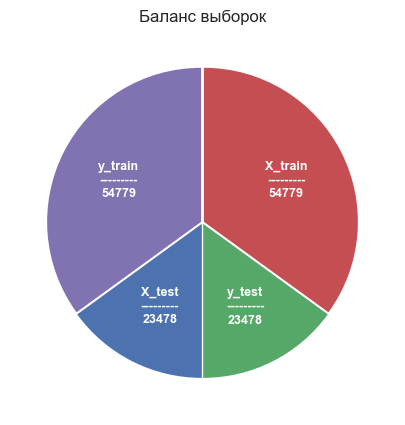

In [7]:
df = df.dropna(axis=0).reset_index(drop=True)

X = df.drop('RainTomorrow', axis=1)
y = df['RainTomorrow']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=31)

print(f"Задание 4.6: Каково среднее значение целевой переменной на тестовой выборке?\n{'-'*75}\nОтвет: {y_test.mean():.2f}\n")

plot_train_test_split_balance(X_train, X_test, y_train, y_test, startangle=216).show('png')

[↑ contents](#contents)

<h2 id='ex_4_7'>Бутстреп реализованный вручную</h2>

Теперь давайте вспомним про бутстреп. Он не понадобится нам для решения этой задачи, но будет полезно реализовать его «вручную».

Сделайте оценку стандартного отклонения для среднего значения минимальной температуры для обучающей выборки (то есть для среднего значения по признаку `MinTemp`). Для этого сгенерируйте `1000` случайных выборок из наших данных — каждая из них должна быть такого же объёма, как и обучающая выборка. Для генерации выборки используйте `np.random.randint()`: сгенерируйте необходимое количество индексов и по ним извлеките соответствующие элементы выборки. Случайность фиксируйте с помощью `np.random.seed(31)`.

Для каждой выборки вычислите среднее значение, а после найдите стандартное отклонение для этих значений. Ответ округлите до двух знаков после точки-разделителя. 

In [8]:
np.random.seed(31)

series_for_this_cell = X_train['MinTemp'].reset_index(drop=True)
max_index = series_for_this_cell.shape[0]

var_for_ans = np.std([series_for_this_cell[np.random.randint(0, max_index, max_index)].mean() for i in range(1000)])

print(f"Задание 4.7: вычислить std для списка средних значений тысячи случайных выборок.\n{'-'*79}\nОтвет: {var_for_ans:.2f}\n")

Задание 4.7: вычислить std для списка средних значений тысячи случайных выборок.
-------------------------------------------------------------------------------
Ответ: 0.03



[↑ contents](#contents)

<h2 id='ex_4_8'>Логистическая регрессия без параметров</h2>

Теперь можно перейти к обучению прогностических моделей. Начнём с того, что построим простейшую `логистическую` регрессию (без настройки гиперпараметров). Это будет та модель, с качеством которой мы будем сравнивать результаты, полученные далее.

В качестве ответа введите значение метрики `roc_auc` на тестовой выборке. Ответ округлите до двух знаков после точки-разделителя.

In [9]:
logreg = LogisticRegression(max_iter=2500, n_jobs=-1)
logreg.fit(X_train, y_train)

print(f"Задание 4.8: вывести значение roc_auc для лог. регрессии.\n{'-'*56}\nОтвет: {roc_auc_score(y_test, logreg.predict(X_test)):.2f}\n")

Задание 4.8: вывести значение roc_auc для лог. регрессии.
--------------------------------------------------------
Ответ: 0.74



Пришлось использовать `max_iter=2500`, т.к. не отключались предупреждения через `warnings.filterwarnings`.

[↑ contents](#contents)

<h2 id='ex_4_9'>DecisionTreeClassifier через GridSearch</h2>

Теперь попробуйте обучить на наших данных другой алгоритм — дерево решений. С помощью `GridSearchCV` сделайте перебор гиперпараметров по следующей сетке:

>params = {'max_leaf_nodes': list(range(2, 10)), 'min_samples_split': [2, 3, 4], 'max_depth': [5,7,9,11]}

Для параметра кросс-валидации `cv` задайте значение `3`. Для решающего дерева определите параметр `random_state=42`. Остальные параметры оставьте по умолчанию.

1. Вычислите значение `roc_auc` для решающего дерева с гиперпараметрами, определёнными в качестве оптимальных. Ответ округлите до двух знаков после точки-разделителя.
2. Какие значения гиперпараметров были выбраны как оптимальные? `max_depth` `max_leaf_nodes` `min_samples_split`

In [10]:
param_grid = {'max_leaf_nodes': list(range(2, 10)), 'min_samples_split': [2, 3, 4], 'max_depth': [5, 7, 9, 11]}

grid_search = GridSearchCV(estimator=DecisionTreeClassifier(random_state=42),
                           param_grid=param_grid,
                           cv=3,
                           n_jobs=-1)

grid_search.fit(X_train, y_train)

print(f"Задание 4.9: вывести значение roc_auc для решающего дерева.\n{'-'*58}\nОтвет п.1: {roc_auc_score(y_test, grid_search.predict(X_test)):.2f}")
print('Ответ п.2: max_depth = {}, max_leaf_nodes = {}, min_samples_split = {}'.format(*grid_search.best_params_.values()))

Задание 4.9: вывести значение roc_auc для решающего дерева.
----------------------------------------------------------
Ответ п.1: 0.70
Ответ п.2: max_depth = 5, max_leaf_nodes = 9, min_samples_split = 2


[↑ contents](#contents)

<h2 id='ex_4_10'>RandomForest</h2>n_estimators=100

К сожалению, деревья решений не помогли нам в улучшении качества модели, так что попробуем ещё уменьшить ошибку с помощью ансамблей.

Теперь постройте случайный лес, включающий 100 деревьев. Задайте параметр `random_state=31`. Остальные параметры оставьте по умолчанию.

Какой теперь будет метрика `roc_auc` на тестовой выборке? Ответ округлите до двух знаков после точки-разделителя.

In [11]:
rf = RandomForestClassifier(n_estimators=100, random_state=31, n_jobs=-1)
rf.fit(X_train, y_train)

print(f"Задание 4.10: вывести значение roc_auc для random forest.\n{'-'*56}\nОтвет: {roc_auc_score(y_test, rf.predict(X_test)):.2f}\n")

Задание 4.10: вывести значение roc_auc для random forest.
--------------------------------------------------------
Ответ: 0.73



[↑ contents](#contents)

<h2 id='ex_4_11'>RandomForest через GridSearch</h2>

Основные параметры, которые отвечают за качество обучения в случайном лесе, следующие:'`max_features`', '`min_samples_leaf`', '`max_depth`'.

Возьмите случайный лес из 100 деревьев и найдите оптимальную комбинацию этих трёх параметров. Сетка для перебора следующая:

>{'max_features': [ 4, 5, 6, 7], 'min_samples_leaf': [3, 5, 7, 9, 11], 'max_depth': [5, 10, 15]}

Перебор осуществите с помощью `GridSearchCV`. Для параметра кросс-валидации `cv` задайте значение 3. Случайности фиксируйте параметром `random_state = 31`. Остальные значения оставьте по умолчанию.

Какое значение `roc_auc` получилось для оптимальных гиперпараметров?

In [12]:
param_grid_rf = {'max_features': [4, 5, 6, 7], 'min_samples_leaf': [3, 5, 7, 9, 11], 'max_depth': [5, 10, 15]}

grid_search_rf = GridSearchCV(estimator=RandomForestClassifier(n_estimators=100, random_state=31, n_jobs=-1),
                              param_grid=param_grid_rf,
                              cv=3,
                              n_jobs=-1)

grid_search_rf.fit(X_train, y_train)

print(f"Задание 4.11: вывести значение roc_auc.\n{'-'*38}\nОтвет: {roc_auc_score(y_test, grid_search_rf.predict(X_test)):.2f}\n")

Задание 4.11: вывести значение roc_auc.
--------------------------------------
Ответ: 0.70



[↑ contents](#contents)

<h2 id='ex_4_12'>Feature importances для модели GridSearch</h2>

Как мы говорили в предыдущем юните, благодаря случайному лесу можно узнать, какие признаки оказывают большее влияние на целевую переменную по сравнению с другими.

Оцените значимость признаков. Отметьте три признака, которые дают наибольший вклад в целевую переменную (в каждой колонке находится как минимум один верный вариант ответа): 

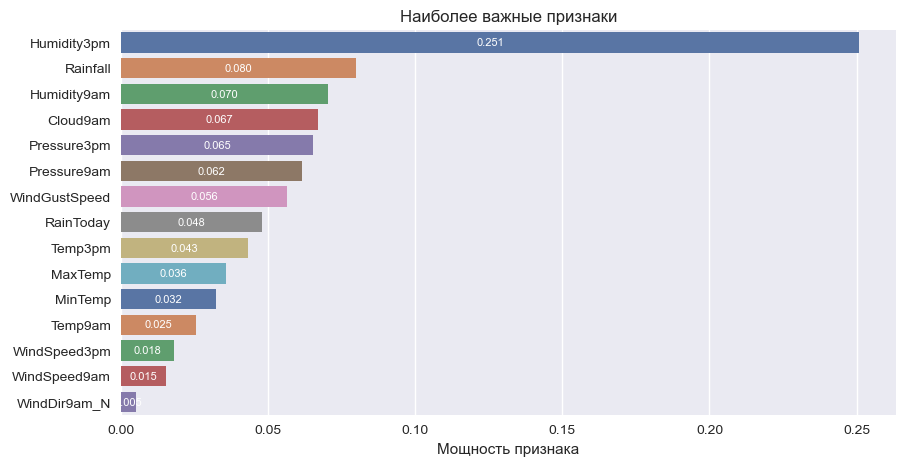

In [13]:
df_for_this_cell = pd.DataFrame([grid_search_rf.feature_names_in_, grid_search_rf.best_estimator_.feature_importances_]).T.sort_values(by=1, ascending=False).head(15)

fig, ax = plt.subplots(figsize=(10, 5))
ax = sns.barplot(data=df_for_this_cell, x=1, y=0, palette='deep', hue=0)
ax.set(xlabel='Мощность признака', ylabel='', title='Наиболее важные признаки')
[ax.bar_label(ax.containers[i], fmt='%.3f', label_type='center', color='white', fontsize=8) for i in range(df_for_this_cell.shape[0])]
plt.show('png')

В итоге победила простая логистическая регрессия, показав лучшие результаты на метрике `roc_auc`.)

[↑ contents](#contents)